In [364]:
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import classification_report,f1_score,roc_curve, auc,roc_auc_score,accuracy_score,recall_score,precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import RFE
from sklearn.externals import joblib

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')

In [203]:
df = pd.read_csv("modelling_data.csv",index_col=0)
df.drop("language",axis=1,inplace=True,)
df.shape

(58635, 24)

In [204]:
df.describe()

,label,duration,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange
count,58635.000000,58635.000000,58635.000000,58635.000000,58635.000000,58635.000000,58635.000000,58635.000000,58635.000000,58635.000000,58635.000000,58635.000000,58635.000000,58635.000000,58635.000000,58635.000000,58635.000000,58635.000000,58635.000000,58635.000000,58635.000000
mean,0.932498,5.176967,0.159614,0.070262,0.160399,0.106853,0.217330,0.110477,5.748214,121.586492,0.917268,0.522095,0.110478,0.159614,0.133203,0.063290,0.273589,0.573830,0.004865,4.197176,4.192311
std,0.250892,1.735240,0.032082,0.012911,0.043554,0.046572,0.031147,0.035014,8.164186,287.438450,0.052762,0.164217,0.089772,0.032082,0.015268,0.001927,0.005123,0.450726,0.028201,2.157028,2.156493
min,0.000000,0.931813,0.010042,0.018363,0.000000,0.000000,0.000114,0.000114,-0.038473,1.811957,0.187236,0.022094,0.000000,0.010042,0.076070,0.062745,0.152381,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.096000,0.140757,0.062342,0.134043,0.085728,0.203013,0.094636,1.784344,6.671788,0.903973,0.433230,0.006174,0.140757,0.123765,0.062745,0.271186,0.234427,0.000000,2.625000,2.625000
50%,1.000000,5.000000,0.161901,0.070048,0.160550,0.113109,0.222240,0.111575,2.370564,10.266875,0.927913,0.548892,0.113007,0.161901,0.130959,0.062992,0.275862,0.486280,0.000000,4.781250,4.781250
75%,1.000000,6.000000,0.181365,0.079033,0.191924,0.133363,0.238672,0.125566,3.884191,27.688274,0.945810,0.642314,0.188745,0.181365,0.139560,0.063241,0.275862,0.827791,0.000000,5.875000,5.875000
max,1.000000,85.250000,0.256628,0.123865,0.269935,0.251605,0.276263,0.258962,51.242801,2774.534731,0.987639,0.907516,0.280000,0.256628,0.271264,0.271186,0.275862,4.311607,0.718750,6.968750,6.968750


In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58635 entries, 1 to 82893
Data columns (total 24 columns):
file         58635 non-null object
label        58635 non-null int64
age_range    58635 non-null object
dialect      58635 non-null object
duration     58635 non-null float64
meanfreq     58635 non-null float64
sd           58635 non-null float64
median       58635 non-null float64
Q25          58635 non-null float64
Q75          58635 non-null float64
IQR          58635 non-null float64
skew         58635 non-null float64
kurt         58635 non-null float64
sp.ent       58635 non-null float64
sfm          58635 non-null float64
mode         58635 non-null float64
centroid     58635 non-null float64
meanfun      58635 non-null float64
minfun       58635 non-null float64
maxfun       58635 non-null float64
meandom      58635 non-null float64
mindom       58635 non-null float64
maxdom       58635 non-null float64
dfrange      58635 non-null float64
dtypes: float64(20), int64(1), o

## Data is ready to be used for modelling

The goal is to classify gender based up on voice. To be fair I will aim for being equally good on both female and male voices in terms of Recall and Precision. The reason for this is that I dont want to have a classifier that have a bias towards male or female. I will assume that this is algined with the goal of the assignment. 

In [206]:
df['label'].value_counts()

1    54677
0     3958
Name: label, dtype: int64

In [207]:
extra_columns = ["file"]
categorical_columns = ["label","age_range","dialect"]
continous_columns = [x for x in df.columns if x not in extra_columns+categorical_columns]

## Balance dataset

Balance the dataset. There are multiple ways to handle the imbalance problem.
- Upsampling
- Downsampling
- Classweights for the classifier
- Adjusting the cost function

For this project there is a limited amount of time. Therefore I have decided to downsample the male observations. I will do this in an aggresive way by making the dataset balanced. Downsampling have the advantages of reducing the data set (which have a cost) and thus allowing for faster iterations. The drawback is that i might loose important information and in general adding more data for a model to train on increase the performance. 

In [208]:
df_male=df[df['label']==1].sample(n=df['label'].value_counts()[0]) # Should have set random_state=42
df_female=df[df['label']==0]
df_sampled=pd.concat([df_male,df_female])
df_sampled['label'].value_counts()

1    3958
0    3958
Name: label, dtype: int64

## One-hot-encode the categorical data. 

See the data preparation steps. After the first itteration is was discovered that,duration,age_range and dialect are feature that wont contribute to a model that genrealises well. Therefore this part of the code is commented out. This actually resulted in lower scores but I belive it will result in a better model in the end! It will also result in a score that will be closer to the real score(the performance of the model when it is used)

In [209]:
#df_dialects=pd.get_dummies(df_sampled['dialect'])
#df_age_range=pd.get_dummies(df_sampled['age_range'])

In [210]:
#df_sampled.columns

In [211]:
#df_sampled = pd.concat([df_sampled, df_dialects], axis=1)
#df_sampled.drop('dialect',inplace=True,axis=1)
#df_sampled = pd.concat([df_sampled, df_age_range], axis=1)
#df_sampled.drop('age_range',inplace=True,axis=1)
#df_sampled.columns

## Drop columns that was discovered to result in overfitting

In [213]:
df_sampled.columns

Index(['file', 'label', 'age_range', 'dialect', 'duration', 'meanfreq', 'sd',
       'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt', 'sp.ent', 'sfm', 'mode',
       'centroid', 'meanfun', 'minfun', 'maxfun', 'meandom', 'mindom',
       'maxdom', 'dfrange'],
      dtype='object')

In [215]:
df_sampled.drop(["duration","dialect","age_range"],axis=1,inplace=True)

In [216]:
df_sampled.head(n=2)

,file,label,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange
51702,/home/niklas_sven_hansson/test/extracted_data/...,1,0.203821,0.065966,0.228541,0.172672,0.248961,0.076289,2.182298,7.820659,0.924983,0.540247,0.238833,0.203821,0.129346,0.062992,0.275862,1.489171,0.0,5.31250,5.31250
32681,/home/niklas_sven_hansson/test/extracted_data/...,1,0.193275,0.062743,0.212152,0.129092,0.251980,0.122888,1.235455,3.892624,0.919530,0.231292,0.266791,0.193275,0.129381,0.062745,0.275862,1.423344,0.0,6.96875,6.96875


## Split the data in test and traning data

Do a 20/80% split of the data. 

In [217]:
x=df_sampled.drop(["file","label"],axis=1)
y=df_sampled["label"]
y=y.astype('int')
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.20, random_state=42)

## Model

In order to find the best possible model the following models will be selected:

- KNN
- Logistic regerssion
- Random Forest
- Gradient Boosting

These models have been selected to represent some of the most commonly used models. They represent some of the models that usually performed the best on many classification problems when structured features have been extracted from the data. They also represent models that are easy to tune and are stable to use. Compare to NN that requires more tuning and are more prune to overfitting. This selection have been done with the limited time in mind. 

### Some help functions 

In [241]:
# Compute ROC curve and ROC area for each class

def plot_auc(y_true,y_prob):
    """Plot the reciver operation characteristic curve and calculate the area under the curve"""
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_prob)
        roc_auc[i] = auc(fpr[i], tpr[i])

    print ("The area under the roc curve is {}".format(roc_auc_score(y_true, y_prob)))
    plt.figure()
    plt.plot(fpr[1], tpr[1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.show()
      
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

### Dummy classifier
I will use a dummy classifier for comparison. This is especially useful when having imblanced data to make sure that the classifier compare bettern than the distibution of the data. The dummy classifier should ofc have a AUC of 0.5 and in this specific case i will expect it to have an accuracy of ish 0.5 since the data is balanced.

             precision    recall  f1-score   support

     Female       0.50      0.49      0.50       775
       Male       0.52      0.53      0.52       809

avg / total       0.51      0.51      0.51      1584

The accuracy is: 0.5107323232323232 %
The area under the roc curve is 0.5079397105147734


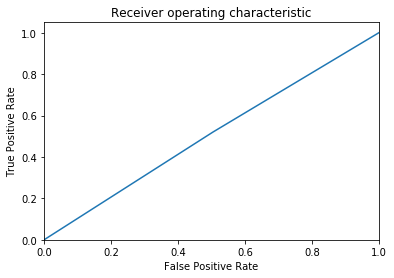

In [242]:
dummy_clf=DummyClassifier()
dummy_clf.fit(X_train,y_train)
y_pred=dummy_clf.predict(X_test)
target_names = ['Female', 'Male']
print(classification_report(y_test, y_pred, target_names=target_names))
print("The accuracy is: {} %".format(accuracy_score(y_test, y_pred)))
plot_auc(y_test,dummy_clf.predict_proba(X_test)[:,1])

### KNN modelling 

Default settings for KNN where the data is scaled using a standards scaler from sklearn

In [220]:
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', KNeighborsClassifier(n_neighbors=3))
                        ])
knn_pipeline.fit(X_train,y_train)
y_pred=knn_pipeline.predict(X_test)
target_names = ['Female', 'Male']
print(classification_report(y_test, y_pred, target_names=target_names))
print("The accuracy is: {} %".format(accuracy_score(y_test, y_pred)))

             precision    recall  f1-score   support

     Female       0.90      0.93      0.91       775
       Male       0.93      0.90      0.91       809

avg / total       0.91      0.91      0.91      1584

The accuracy is: 0.9128787878787878 %


Set up a grid search in order to tune the hyper paramters

In [221]:
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', KNeighborsClassifier(n_neighbors=3))
                        ])
param_grid = [
    {
        'knn__n_neighbors': [1,3,5,10],
        'knn__weights': ['uniform','distance'],
    },
]
knn_grid = GridSearchCV(knn_pipeline, cv=3, n_jobs=-1, param_grid=param_grid,refit=True)
knn_grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'knn__n_neighbors': [1, 3, 5, 10], 'knn__weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

             precision    recall  f1-score   support

     Female       0.90      0.93      0.91       775
       Male       0.93      0.90      0.91       809

avg / total       0.91      0.91      0.91      1584

The accuracy is: 0.9122474747474747 %
The area under the roc curve is 0.9555867458830097


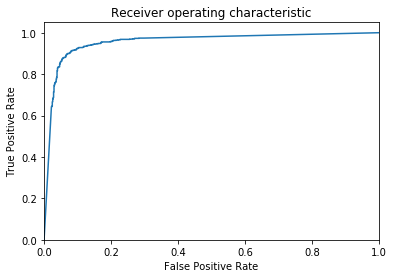

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.013999,0.003262,0.288403,0.057238,1,uniform,"{'knn__n_neighbors': 1, 'knn__weights': 'unifo...",0.883468,0.897205,0.889100,0.889924,0.005639,7,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.015659,0.002804,0.296265,0.063431,1,distance,"{'knn__n_neighbors': 1, 'knn__weights': 'dista...",0.883468,0.897205,0.889100,0.889924,0.005639,7,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.015249,0.005059,0.354267,0.073056,3,uniform,"{'knn__n_neighbors': 3, 'knn__weights': 'unifo...",0.899100,0.904311,0.899052,0.900821,0.002468,5,0.946221,0.945511,0.946471,0.946068,0.000407
3,0.010171,0.002904,0.296999,0.007011,3,distance,"{'knn__n_neighbors': 3, 'knn__weights': 'dista...",0.900521,0.904311,0.900000,0.901611,0.001921,4,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.010359,0.002281,0.328735,0.073856,5,uniform,"{'knn__n_neighbors': 5, 'knn__weights': 'unifo...",0.904311,0.904784,0.904739,0.904611,0.000213,3,0.927268,0.931770,0.930365,0.929801,0.001880
5,0.010006,0.002438,0.293026,0.029409,5,distance,"{'knn__n_neighbors': 5, 'knn__weights': 'dista...",0.905732,0.905258,0.905687,0.905559,0.000214,1,1.000000,1.000000,1.000000,1.000000,0.000000
6,0.008157,0.000140,0.335305,0.022814,10,uniform,"{'knn__n_neighbors': 10, 'knn__weights': 'unif...",0.903363,0.899574,0.893365,0.898768,0.004121,6,0.917555,0.911395,0.915443,0.914798,0.002556
7,0.012049,0.002514,0.434400,0.044216,10,distance,"{'knn__n_neighbors': 10, 'knn__weights': 'dist...",0.908100,0.906206,0.902370,0.905559,0.002384,1,1.000000,1.000000,1.000000,1.000000,0.000000


In [243]:
y_pred=knn_grid.predict(X_test)
target_names = ['Female', 'Male']
print(classification_report(y_test, y_pred, target_names=target_names))
print("The accuracy is: {} %".format(accuracy_score(y_test, y_pred)))
plot_auc(y_test,knn_grid.predict_proba(X_test)[:,1])

pd.DataFrame(knn_grid.cv_results_)

### Logistic regerssion 

First I test the performance using a defualt logistic regerssion model

In [229]:
log_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('rf', LogisticRegression())
                        ])
log_pipeline.fit(X_train,y_train)
y_pred=log_pipeline.predict(X_test)
target_names = ['Female', 'Male']
print(classification_report(y_test, y_pred, target_names=target_names))
print("The accuracy is: {} %".format(accuracy_score(y_test, y_pred)))

             precision    recall  f1-score   support

     Female       0.88      0.86      0.87       775
       Male       0.87      0.89      0.88       809

avg / total       0.87      0.87      0.87      1584

The accuracy is: 0.8731060606060606 %


In [230]:
log_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('log', LogisticRegression())
                        ])
param_grid = [
    {
        "log__penalty" : ['l1', 'l2'],
        "log__tol":[1e-3,1e-4,1e-5],
        "log__C":[0.001,0.01,0.1,1,10,100],
    },
]
log_grid = GridSearchCV(log_pipeline, cv=3, n_jobs=-1, param_grid=param_grid,refit=True)
log_grid.fit(X_train,y_train)
y_pred=log_grid.predict(X_test)


             precision    recall  f1-score   support

     Female       0.88      0.87      0.87       775
       Male       0.87      0.89      0.88       809

avg / total       0.88      0.88      0.88      1584

The accuracy is: 0.8768939393939394 %
The area under the roc curve is 0.9320483272857769


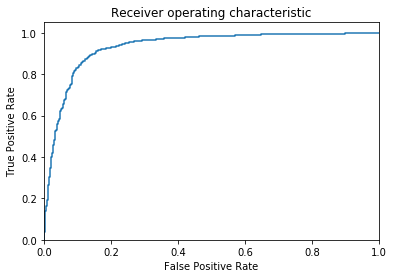

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__penalty,param_log__tol,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.014871,0.001373,0.023845,0.002598,0.001,l1,0.001,"{'log__C': 0.001, 'log__penalty': 'l1', 'log__...",0.855045,0.880152,0.867773,0.867656,0.010251,31,0.872068,0.860460,0.866177,0.866235,0.004739
1,0.079455,0.017925,0.035412,0.016631,0.001,l1,0.0001,"{'log__C': 0.001, 'log__penalty': 'l1', 'log__...",0.855045,0.880152,0.867773,0.867656,0.010251,31,0.872068,0.860460,0.866177,0.866235,0.004739
2,0.060568,0.034333,0.026615,0.002838,0.001,l1,1e-05,"{'log__C': 0.001, 'log__penalty': 'l1', 'log__...",0.855045,0.880152,0.867773,0.867656,0.010251,31,0.872068,0.860460,0.866177,0.866235,0.004739
3,0.056344,0.052252,0.029146,0.012529,0.001,l2,0.001,"{'log__C': 0.001, 'log__penalty': 'l2', 'log__...",0.851255,0.879678,0.864455,0.865130,0.011614,34,0.867330,0.864487,0.865230,0.865682,0.001204
4,0.058014,0.025855,0.034436,0.003588,0.001,l2,0.0001,"{'log__C': 0.001, 'log__penalty': 'l2', 'log__...",0.851255,0.879678,0.864455,0.865130,0.011614,34,0.867330,0.864487,0.865230,0.865682,0.001204
5,0.064085,0.002642,0.043671,0.012291,0.001,l2,1e-05,"{'log__C': 0.001, 'log__penalty': 'l2', 'log__...",0.851255,0.879678,0.864455,0.865130,0.011614,34,0.867330,0.864487,0.865230,0.865682,0.001204
6,0.047798,0.015240,0.032302,0.024584,0.01,l1,0.001,"{'log__C': 0.01, 'log__penalty': 'l1', 'log__t...",0.863572,0.889626,0.873460,0.875553,0.010740,28,0.881071,0.869936,0.877546,0.876184,0.004647
7,0.038425,0.024702,0.025086,0.016372,0.01,l1,0.0001,"{'log__C': 0.01, 'log__penalty': 'l1', 'log__t...",0.863572,0.889626,0.873460,0.875553,0.010740,28,0.881071,0.869699,0.877546,0.876105,0.004753
8,0.049495,0.015875,0.034875,0.027128,0.01,l1,1e-05,"{'log__C': 0.01, 'log__penalty': 'l1', 'log__t...",0.863572,0.889626,0.873460,0.875553,0.010740,28,0.881071,0.869699,0.877546,0.876105,0.004753
9,0.091653,0.046640,0.025660,0.002563,0.01,l2,0.001,"{'log__C': 0.01, 'log__penalty': 'l2', 'log__t...",0.873993,0.896258,0.879621,0.883291,0.009453,25,0.888178,0.881071,0.886073,0.885107,0.002981


In [323]:
target_names = ['Female', 'Male']
print(classification_report(y_test, log_grid.predict(X_test), target_names=target_names))
print("The accuracy is: {} %".format(accuracy_score(y_test, log_grid.predict(X_test))))
plot_auc(y_test,log_grid.predict_proba(X_test)[:,1])

pd.DataFrame(log_grid.cv_results_)

### Random forest model

First I test the performance using a default randomforest model

In [232]:
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('rf', RandomForestClassifier(n_jobs=-1))
                        ])
rf_pipeline.fit(X_train,y_train)
y_pred=rf_pipeline.predict(X_test)
target_names = ['Female', 'Male']
print(classification_report(y_test, y_pred, target_names=target_names))
print("The accuracy is: {} %".format(accuracy_score(y_test, y_pred)))

             precision    recall  f1-score   support

     Female       0.89      0.91      0.90       775
       Male       0.92      0.90      0.91       809

avg / total       0.91      0.91      0.91      1584

The accuracy is: 0.9053030303030303 %


In [233]:
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('rf', RandomForestClassifier())
                        ])
param_grid = [
    {
        'rf__n_estimators': [10,50,100,200,400,600],
        'rf__max_features': [5,10,15,None],
        'rf__max_depth': [5,8,10,None],
    },
]
rf_grid = GridSearchCV(rf_pipeline, cv=3, n_jobs=-1, param_grid=param_grid,refit=True)
rf_grid.fit(X_train,y_train)


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
      ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'rf__n_estimators': [10, 50, 100, 200, 400, 600], 'rf__max_features': [5, 10, 15, None], 'rf__max_depth': [5, 8, 10, None]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

             precision    recall  f1-score   support

     Female       0.90      0.92      0.91       775
       Male       0.92      0.90      0.91       809

avg / total       0.91      0.91      0.91      1584

The accuracy is: 0.9122474747474747 %
The area under the roc curve is 0.968378324494597


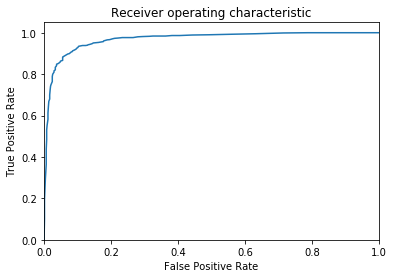

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__max_features,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.114662,0.009800,0.005908,0.000086,5,5,10,"{'rf__max_depth': 5, 'rf__max_features': 5, 'r...",0.880625,0.901468,0.889100,0.890398,0.008559,96,0.901445,0.906183,0.904548,0.904059,0.001965
1,0.582724,0.001859,0.019082,0.000084,5,5,50,"{'rf__max_depth': 5, 'rf__max_features': 5, 'r...",0.883941,0.902890,0.889573,0.892135,0.007945,84,0.906894,0.909263,0.905495,0.907217,0.001555
2,1.133810,0.005465,0.035632,0.000691,5,5,100,"{'rf__max_depth': 5, 'rf__max_features': 5, 'r...",0.883941,0.902890,0.890521,0.892451,0.007856,82,0.906894,0.904288,0.908337,0.906506,0.001676
3,2.263987,0.011148,0.068291,0.001624,5,5,200,"{'rf__max_depth': 5, 'rf__max_features': 5, 'r...",0.882046,0.902416,0.889100,0.891188,0.008446,91,0.908316,0.905473,0.909285,0.907691,0.001618
4,4.478340,0.018565,0.131495,0.000489,5,5,400,"{'rf__max_depth': 5, 'rf__max_features': 5, 'r...",0.882046,0.901942,0.889573,0.891188,0.008203,91,0.908789,0.905236,0.909522,0.907849,0.001872
5,6.711697,0.010603,0.197160,0.000744,5,5,600,"{'rf__max_depth': 5, 'rf__max_features': 5, 'r...",0.882994,0.903837,0.888152,0.891661,0.008864,89,0.908789,0.904762,0.907390,0.906980,0.001670
6,0.195577,0.000830,0.005204,0.000051,5,10,10,"{'rf__max_depth': 5, 'rf__max_features': 10, '...",0.888205,0.897679,0.893839,0.893241,0.003891,78,0.911158,0.903814,0.914732,0.909902,0.004545
7,0.968879,0.004627,0.018106,0.000156,5,10,50,"{'rf__max_depth': 5, 'rf__max_features': 10, '...",0.884415,0.897679,0.890047,0.890714,0.005436,94,0.911869,0.905236,0.910706,0.909270,0.002892
8,1.923334,0.019886,0.034797,0.000838,5,10,100,"{'rf__max_depth': 5, 'rf__max_features': 10, '...",0.883468,0.898626,0.890047,0.890714,0.006207,94,0.910922,0.905236,0.911416,0.909191,0.002804
9,3.836850,0.005296,0.066511,0.000606,5,10,200,"{'rf__max_depth': 5, 'rf__max_features': 10, '...",0.883468,0.899574,0.893365,0.892135,0.006633,84,0.912106,0.904288,0.914259,0.910218,0.004284


In [245]:
y_pred=rf_grid.predict(X_test)
target_names = ['Female', 'Male']
print(classification_report(y_test, y_pred, target_names=target_names))
print("The accuracy is: {} %".format(accuracy_score(y_test, y_pred)))
plot_auc(y_test,rf_grid.predict_proba(X_test)[:,1])

pd.DataFrame(rf_grid.cv_results_)

### Gradient boosting

I will use the extrem gradient boosting, xgb library. 

In [235]:
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('xgb', XGBClassifier(n_jobs=-1))
                        ])
xgb_pipeline.fit(X_train,y_train)
y_pred=xgb_pipeline.predict(X_test)
target_names = ['Female', 'Male']
print(classification_report(y_test, y_pred, target_names=target_names))
print("The accuracy is: {} %".format(accuracy_score(y_test, y_pred)))


             precision    recall  f1-score   support

     Female       0.89      0.91      0.90       775
       Male       0.91      0.89      0.90       809

avg / total       0.90      0.90      0.90      1584

The accuracy is: 0.9008838383838383 %


In [236]:

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('xgb', XGBClassifier(n_jobs=-1))
                        ])
param_grid = [
    {
        'xgb__n_estimators': [10,50,100,200,400,600],
        'xgb__learning_rate' : [0.05,0.1,0.15,0.20,0.25,0.3,0.35],
        'xgb__max_depth' : [3,5,7,9,11],
        'xgb__min_child_weight' : [1,2,4,6]
    },
]
xgb_grid = GridSearchCV(xgb_pipeline, cv=3, n_jobs=-1, param_grid=param_grid,refit=True,verbose=2)
xgb_grid.fit(X_train,y_train)


Fitting 3 folds for each of 840 candidates, totalling 2520 fits
[CV] xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=10 
[CV] xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50 
[CV] xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=10 
[CV] xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=10 
[CV] xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100 
[CV] xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50 
[CV] xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50 
[CV] xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=10, total=   0.1s
[CV] xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_w

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s


[CV]  xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=100, total=   0.7s
[CV] xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=100, total=   0.8s
[CV] xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=400, total=   2.8s
[CV] xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=400, total=   2.8s
[CV] xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=100, total=   0.7s
[CV] xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_chil

[CV]  xgb__learning_rate=0.05, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=100, total=   1.3s
[CV] xgb__learning_rate=0.05, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=600, total=   4.2s
[CV] xgb__learning_rate=0.05, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=100, total=   1.3s
[CV] xgb__learning_rate=0.05, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=600, total=   4.1s
[CV] xgb__learning_rate=0.05, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=600, total=   4.1s
[CV] xgb__learning_rate=0.05, xgb__max_depth=5, xgb__min_chil

[CV]  xgb__learning_rate=0.05, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=200, total=   2.4s
[CV] xgb__learning_rate=0.05, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=200, total=   2.4s
[CV] xgb__learning_rate=0.05, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=600, total=   7.2s
[CV] xgb__learning_rate=0.05, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=600, total=   7.0s
[CV] xgb__learning_rate=0.05, xgb__max_depth=5, xgb__min_child_weight=6, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=600, total=   6.9s
[CV] xgb__learning_rate=0.05, xgb__max_depth=5, xgb__min_child

[CV]  xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=200, total=   3.6s
[CV] xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=50, total=   0.9s
[CV] xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   48.6s


[CV]  xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=200, total=   3.4s
[CV] xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=200, total=   3.5s
[CV] xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=200, total=   3.4s
[CV] xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=600, total=   9.9s
[CV] xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=600, total=   9.9s
[CV] xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_chil

[CV]  xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=600, total=   9.0s
[CV] xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=600, total=   9.1s
[CV] xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weigh

[CV]  xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=50, total=   1.0s
[CV] xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=50, total=   1.0s
[CV] xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=50, total=   1.0s
[CV] xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=400, total=   7.8s
[CV] xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weig

[CV]  xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=400, total=   7.0s
[CV] xgb__learning_rate=0.05, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=50, total=   1.3s
[CV] xgb__learning_rate=0.05, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=100, total=   2.6s
[CV] xgb__learning_rate=0.05, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=400, total=   7.1s
[CV] xgb__learning_rate=0.05, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=100, total=   2.6s
[CV] xgb__learning_rate=0.05, xgb__max_depth=11, xgb__m

[CV] xgb__learning_rate=0.05, xgb__max_depth=11, xgb__min_child_weight=4, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=11, xgb__min_child_weight=4, xgb__n_estimators=100, total=   2.2s
[CV] xgb__learning_rate=0.05, xgb__max_depth=11, xgb__min_child_weight=4, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=400, total=   8.7s
[CV] xgb__learning_rate=0.05, xgb__max_depth=11, xgb__min_child_weight=4, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=11, xgb__min_child_weight=4, xgb__n_estimators=200, total=   4.3s
[CV] xgb__learning_rate=0.05, xgb__max_depth=11, xgb__min_child_weight=4, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=11, xgb__min_child_weight=4, xgb__n_estimators=200, total=   4.4s
[CV] xgb__learning_rate=0.05, xgb__max_depth=11, xgb__min_child_weight=4, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=11, xgb__min_child_we

[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.05, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=400, total=   7.5s
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=400, total=   2.8s
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=400, total=   2.8s
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=10, total=   0.1s
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=10 


[Parallel(n_jobs=-1)]: Done 371 tasks      | elapsed:  2.6min


[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=10, total=   0.1s
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=10, total=   0.1s
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=400, total=   2.8s
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=50, total=   0.4s
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=50, total=   0.4s
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n

[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=50, total=   0.4s
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=400, total=   2.7s
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=400, total=   2.8s
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=100, total=   0.7s
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estima

[CV]  xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=400, total=   4.8s
[CV] xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=100, total=   1.2s
[CV] xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=400, total=   4.8s
[CV] xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=200, total=   2.3s
[CV] xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=200, total=   2.4s
[CV] xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=2

[CV]  xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=6, xgb__n_estimators=200, total=   2.2s
[CV] xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=6, xgb__n_estimators=600 
[CV] xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=6, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=600, total=   6.5s
[CV] xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=6, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=600, total=   6.6s
[CV] xgb__learning_rate=0.1, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.1, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimato

[CV]  xgb__learning_rate=0.1, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.1, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.1, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.1, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=50, total=   0.9s
[CV] xgb__learning_rate=0.1, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=50, total=   0.9s
[CV] xgb__learning_rate=0.1, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_

[CV] xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=400, total=   5.5s
[CV] xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=400, total=   5.7s
[CV] xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=50, total=   1.2s
[CV] xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=400, total=   5.6s
[CV] xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estima

[CV]  xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=100, total=   2.0s
[CV] xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=100, total=   2.0s
[CV] xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=400, total=   6.9s
[CV] xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=200, total=   3.6s
[CV] xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=200, total=   3.7s
[CV] xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=4

[Parallel(n_jobs=-1)]: Done 654 tasks      | elapsed:  4.4min


[CV]  xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=600, total=   8.5s
[CV] xgb__learning_rate=0.1, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=200, total=   4.4s
[CV] xgb__learning_rate=0.1, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=600, total=   8.7s
[CV] xgb__learning_rate=0.1, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=600, total=   8.6s
[CV] xgb__learning_rate=0.1, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=200, total=   4.4s
[CV] xgb__learning_rate=0.1, xgb__max_depth=11, xgb__min_child_w

[CV]  xgb__learning_rate=0.1, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=600, total=   9.6s
[CV] xgb__learning_rate=0.1, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.1, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=600, total=   9.6s
[CV] xgb__learning_rate=0.1, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.1, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.1, xgb__max_depth=11, xgb__min_child_weigh

[CV]  xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=10, total=   0.1s
[CV] xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=50, total=   0.4s
[CV] xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=50, total=   0.4s
[CV] xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=50, total=   0.4s
[CV] xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=100, total=   0.7s
[CV] xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weig

[CV]  xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=50, total=   0.4s
[CV] xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=400, total=   2.7s
[CV] xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=100, total=   0.7s
[CV] xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=100, total=   0.7s
[CV] xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=100, total=   0.7s
[CV] xgb__learning_rate=0.15, xgb__max_depth=3, xgb__min_child

[CV]  xgb__learning_rate=0.15, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=100, total=   1.2s
[CV] xgb__learning_rate=0.15, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=400, total=   4.6s
[CV] xgb__learning_rate=0.15, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=200, total=   2.3s
[CV] xgb__learning_rate=0.15, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=200, total=   2.4s
[CV] xgb__learning_rate=0.15, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=200, total=   2.3s
[CV] xgb__learning_rate=0.15, xgb__max_depth=5, xgb__min_chil

[CV]  xgb__learning_rate=0.15, xgb__max_depth=5, xgb__min_child_weight=6, xgb__n_estimators=200, total=   2.2s
[CV] xgb__learning_rate=0.15, xgb__max_depth=5, xgb__min_child_weight=6, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=600, total=   6.3s
[CV] xgb__learning_rate=0.15, xgb__max_depth=5, xgb__min_child_weight=6, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=600, total=   6.3s
[CV] xgb__learning_rate=0.15, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.15, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.15, xgb__max_depth=7, xgb__min_child_we

[CV]  xgb__learning_rate=0.15, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.15, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.15, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.15, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=50, total=   0.8s
[CV] xgb__learning_rate=0.15, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=50, total=   0.8s
[CV] xgb__learning_rate=0.15, xgb__max_depth=7, xgb__min_child_weight=

[CV]  xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=50, total=   1.1s
[CV] xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=400, total=   5.1s
[CV] xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=400, total=   5.4s
[CV]  xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=50, total=   1.1s
[CV] xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=100 
[CV] xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=100, total=   2.1s
[CV] xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_

[CV]  xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=100, total=   1.9s
[CV] xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=100, total=   1.9s
[CV] xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=100, total=   1.9s
[CV] xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=400, total=   6.1s
[CV] xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=200, total=   3.4s
[CV] xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_chil

[CV]  xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=600, total=   7.4s
[CV] xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=600, total=   7.5s
[CV] xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=200, total=   4.0s
[CV] xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=600, total=   7.7s
[CV] xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=200, total=   4.0s
[CV] xgb__learning_rate=0.15, xgb__max_depth=11, xgb__m

[Parallel(n_jobs=-1)]: Done 1019 tasks      | elapsed:  6.7min


[CV]  xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=10, total=   0.3s
[CV]  xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=200, total=   4.0s
[CV] xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=10 
[CV] xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=10, total=   0.3s
[CV] xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=50, total=   1.2s
[CV] xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_ch

[CV] xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=50, total=   1.0s
[CV] xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=50, total=   1.0s
[CV] xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=50, total=   1.0s
[CV] xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=4, xgb__n_estimators=400, total=   5.9s
[CV] xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=

[CV] xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=600, total=   7.9s
[CV] xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.15, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=600, total=   7.7s
[CV] xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=100, total=   0.8s
[CV] xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=100, total=   0.7s
[CV] xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_e

[CV]  xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=400, total=   2.9s
[CV] xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=200, total=   1.4s
[CV] xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=200, total=   1.4s
[CV] xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=200, total=   1.4s
[CV] xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=600, total=   4.2s
[CV] xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=6

[CV] xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=600, total=   6.5s
[CV] xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=600, total=   6.6s
[CV] xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=10, total=   0.1s
[CV] xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=10, total=   0.1s
[CV] xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=

[CV]  xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=50, total=   0.9s
[CV] xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=6, xgb__n_estimators=400, total=   4.2s
[CV] xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=50, total=   0.9s
[CV] xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=6, xgb__n_estimators=400, total=   4.2s
[CV] xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=1, xgb

[CV] xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=100, total=   1.5s
[CV] xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=400, total=   5.4s
[CV] xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=100, total=   1.5s
[CV] xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=100, total=   1.6s
[CV] xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estim

[CV]  xgb__learning_rate=0.2, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=100, total=   2.0s
[CV] xgb__learning_rate=0.2, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=600, total=   6.6s
[CV] xgb__learning_rate=0.2, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=600, total=   6.6s
[CV] xgb__learning_rate=0.2, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=200, total=   3.6s
[CV] xgb__learning_rate=0.2, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=600, total=   6.7s
[CV] xgb__learning_rate=0.2, xgb__max_depth=9, xgb__min_child_weight=1

[CV] xgb__learning_rate=0.2, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=600, total=   7.3s
[CV] xgb__learning_rate=0.2, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.2, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.2, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=200, total=   3.3s
[CV] xgb__learning_rate=0.2, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=

[CV] xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=10, total=   0.3s
[CV] xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=50, total=   1.2s
[CV] xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=50, total=   1.2s
[CV] xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=50, total=   1.2s
[CV] xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_es

[CV] xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=4, xgb__n_estimators=400, total=   5.3s
[CV] xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=4, xgb__n_estimators=400, total=   5.5s
[CV] xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=100, total=   1.8s
[CV] xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=100, total=   1.9s
[CV] xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.2, xgb__max_depth=11, xgb__min_child_weight=6, xg

[CV] xgb__learning_rate=0.25, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=100, total=   0.7s
[CV] xgb__learning_rate=0.25, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=100, total=   0.7s
[CV] xgb__learning_rate=0.25, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=400 


[Parallel(n_jobs=-1)]: Done 1464 tasks      | elapsed:  9.4min


[CV]  xgb__learning_rate=0.25, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=200, total=   1.4s
[CV] xgb__learning_rate=0.25, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=200, total=   1.4s
[CV] xgb__learning_rate=0.25, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=600, total=   4.2s
[CV] xgb__learning_rate=0.25, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=200, total=   1.4s
[CV] xgb__learning_rate=0.25, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=600, total=   4.2s
[CV] xgb__learning_rate=0.25, xgb__max_depth=3, xgb__min_chil

[CV]  xgb__learning_rate=0.25, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=600, total=   4.0s
[CV] xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=10, total=   0.1s
[CV]  xgb__learning_rate=0.25, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=600, total=   4.0s
[CV] xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=10 
[CV] xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=10, total=   0.1s
[CV] xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weigh

[CV]  xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=10, total=   0.1s
[CV] xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=50, total=   0.6s
[CV] xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=50, total=   0.6s
[CV] xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=50, total=   0.6s
[CV] xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=400, total=   4.4s
[CV] xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weig

[CV]  xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weight=6, xgb__n_estimators=400, total=   4.0s
[CV] xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=50, total=   0.9s
[CV] xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=5, xgb__min_child_weight=6, xgb__n_estimators=400, total=   4.0s
[CV] xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=100, total=   1.7s
[CV] xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=100, total=   1.7s
[CV] xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_child

[CV]  xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=100, total=   1.5s
[CV] xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=400, total=   5.0s
[CV] xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=200, total=   2.8s
[CV] xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=200, total=   2.8s
[CV] xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=600, total=   6.6s
[CV] xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_chil

[CV]  xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=200, total=   3.3s
[CV] xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=600, total=   6.1s
[CV] xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=200, total=   3.4s
[CV] xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=10, total=   0.2s
[CV]  xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=200, total=   3.4s
[CV] xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=10 
[CV] xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_w

[CV]  xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=200, total=   3.0s
[CV] xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=50, total=   0.9s
[CV] xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=50, total=   0.9s
[CV] xgb__learning_rate=0.25, xgb__max_depth=9, xgb__min_child_weight

[CV] xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=50, total=   1.1s
[CV] xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=400, total=   5.5s
[CV] xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=50, total=   1.1s
[CV] xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=400, total=   5.5s
[CV] xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weigh

[CV]  xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weight=4, xgb__n_estimators=400, total=   5.1s
[CV] xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=100, total=   1.8s
[CV] xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weight=4, xgb__n_estimators=400, total=   5.0s
[CV] xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=100, total=   1.8s
[CV] xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.25, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=100, total=   1.8s
[CV] xgb__learning_rate=0.25, xgb__max_depth=11, xgb

[CV]  xgb__learning_rate=0.3, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=100, total=   0.7s
[CV] xgb__learning_rate=0.3, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=200, total=   1.4s
[CV] xgb__learning_rate=0.3, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=200, total=   1.4s
[CV] xgb__learning_rate=0.3, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=600, total=   4.2s
[CV] xgb__learning_rate=0.3, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=200, total=   1.4s
[CV] xgb__learning_rate=0.3, xgb__max_depth=3, xgb__min_child_weight=2

[CV] xgb__learning_rate=0.3, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=600, total=   4.0s
[CV] xgb__learning_rate=0.3, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=600, total=   4.0s
[CV] xgb__learning_rate=0.3, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.3, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=10, total=   0.1s
[CV] xgb__learning_rate=0.3, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=

[CV] xgb__learning_rate=0.3, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=50 
[CV] xgb__learning_rate=0.3, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=50, total=   0.6s
[CV] xgb__learning_rate=0.3, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=50, total=   0.6s
[CV] xgb__learning_rate=0.3, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=50, total=   0.6s
[CV] xgb__learning_rate=0.3, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=400, total=   4.1s
[CV] xgb__learning_rate=0.3, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=1

[CV] xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=50, total=   0.9s
[CV] xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=5, xgb__min_child_weight=6, xgb__n_estimators=400, total=   3.9s
[CV] xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=100, total=   1.6s
[CV] xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=100, total=   1.7s
[CV] xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estima

[CV]  xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=400, total=   4.8s
[CV] xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=200, total=   2.7s
[CV] xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=200, total=   2.7s
[CV] xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=600, total=   6.3s
[CV] xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=600, total=   6.1s
[CV] xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=4

[Parallel(n_jobs=-1)]: Done 1991 tasks      | elapsed: 12.2min


[CV] xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=50, total=   0.8s
[CV] xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=50, total=   0.8s
[CV] xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=50

[CV]  xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=400, total=   5.1s
[CV] xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=50, total=   1.1s
[CV] xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=400, total=   5.3s
[CV] xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=100, total=   1.8s
[CV] xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=400, total=   5.3s
[CV] xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=2,

[CV] xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=400, total=   4.7s
[CV] xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=100, total=   1.7s
[CV] xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=600, total=   5.9s
[CV] xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=600, total=   6.0s
[CV] xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estim

[CV] xgb__learning_rate=0.3, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=200, total=   3.0s
[CV] xgb__learning_rate=0.3, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=600, total=   6.7s
[CV] xgb__learning_rate=0.3, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=200, total=   3.1s
[CV] xgb__learning_rate=0.3, xgb__max_depth=11, xgb__min_child_weight=4, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=11, xgb__min_child_weight=4, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.3, xgb__max_depth=11, xgb__min_child_weight=4, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.3, xgb__max_depth=11, xgb__min_child_weight=2, xgb__

[CV] xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=10, total=   0.1s
[CV] xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=10, total=   0.1s
[CV] xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=10, total=   0.1s
[CV] xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, total=   0.4s
[CV] xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_esti

[CV] xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=600, total=   4.1s
[CV] xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=50, total=   0.4s
[CV] xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=400, total=   2.7s
[CV] xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=2, xgb__n_estimators=400, total=   2.9s
[CV] xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=4, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=4, xgb_

[CV]  xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=6, xgb__n_estimators=400, total=   2.7s
[CV] xgb__learning_rate=0.35, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=200 
[CV] xgb__learning_rate=0.35, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=100, total=   1.2s
[CV] xgb__learning_rate=0.35, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=100, total=   1.2s
[CV] xgb__learning_rate=0.35, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=100, total=   1.2s
[CV] xgb__learning_rate=0.35, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=3, xgb__min_child_weight=6, xg

[CV] xgb__learning_rate=0.35, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=200, total=   2.1s
[CV] xgb__learning_rate=0.35, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=200, total=   2.1s
[CV] xgb__learning_rate=0.35, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=200, total=   2.2s
[CV] xgb__learning_rate=0.35, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=5, xgb__min_child_weight=2, xgb__n_estimators=600, total=   5.5s
[CV] xgb__learning_rate=0.35, xgb__max_depth=5, xgb__min_child_weight=4, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=5, xgb__min_child_weight=2, xg

[CV] xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=200, total=   2.8s
[CV] xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=200, total=   2.9s
[CV] xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_e

[CV] xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=10, total=   0.2s
[CV] xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=50, total=   0.8s
[CV] xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=50 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=50, total=   0.8s
[CV] xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=50, total=   0.8s
[CV] xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=6, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=7, xgb__min_child_weight=4, xgb__n_es

[CV] xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=50, total=   1.0s
[CV] xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=400, total=   4.8s
[CV] xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=100, total=   1.7s
[CV] xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=1, xgb__n_estimators=400, total=   4.8s
[CV] xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=2, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=2, xgb

[CV] xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=200 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=100, total=   1.6s
[CV] xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=100, total=   1.6s
[CV] xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=4, xgb__n_estimators=600, total=   5.5s
[CV] xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=400 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=200, total=   2.7s
[CV] xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=6, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=9, xgb__min_child_weight=4, xg

[CV]  xgb__learning_rate=0.35, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=600, total=   6.3s
[CV] xgb__learning_rate=0.35, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=11, xgb__min_child_weight=1, xgb__n_estimators=600, total=   6.3s
[CV] xgb__learning_rate=0.35, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=200, total=   2.9s
[CV] xgb__learning_rate=0.35, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=600 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=200, total=   3.0s
[CV] xgb__learning_rate=0.35, xgb__max_depth=11, xgb__min_child_weight=4, xgb__n_estimators=10 
[CV]  xgb__learning_rate=0.35, xgb__max_depth=11, xgb__min_child_weight=2, xgb__n_estimators=200, total=   2.9s
[CV] xgb__learning_rate=0.35, xgb__max_depth=11, xgb_

[CV]  xgb__learning_rate=0.35, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=200, total=   2.7s
[CV]  xgb__learning_rate=0.35, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=400, total=   3.2s
[CV]  xgb__learning_rate=0.35, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=400, total=   4.0s
[CV]  xgb__learning_rate=0.35, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=400, total=   3.7s
[CV]  xgb__learning_rate=0.35, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=600, total=   3.5s
[CV]  xgb__learning_rate=0.35, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=600, total=   4.3s
[CV]  xgb__learning_rate=0.35, xgb__max_depth=11, xgb__min_child_weight=6, xgb__n_estimators=600, total=   4.2s


[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed: 15.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight...ate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'xgb__n_estimators': [10, 50, 100, 200, 400, 600], 'xgb__learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], 'xgb__max_depth': [3, 5, 7, 9, 11], 'xgb__min_child_weight': [1, 2, 4, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

             precision    recall  f1-score   support

     Female       0.90      0.92      0.91       775
       Male       0.92      0.90      0.91       809

avg / total       0.91      0.91      0.91      1584

The accuracy is: 0.913510101010101 %
The area under the roc curve is 0.9709254754974281


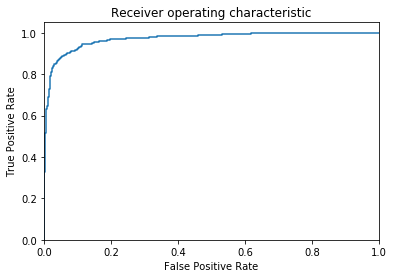

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_weight,param_xgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.086026,0.006956,0.003746,0.000062,0.05,3,1,10,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",0.868309,0.882520,0.873934,0.874921,0.005844,837,0.889837,0.875622,0.885362,0.883607,5.934375e-03
1,0.287080,0.033338,0.005059,0.000036,0.05,3,1,50,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",0.868309,0.890573,0.881991,0.880291,0.009169,824,0.894812,0.892679,0.887731,0.891741,2.965933e-03
2,0.547781,0.082499,0.009159,0.000891,0.05,3,1,100,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",0.895310,0.902416,0.892417,0.896715,0.004201,796,0.912817,0.911869,0.909285,0.911324,1.492724e-03
3,0.869708,0.025493,0.014808,0.000561,0.05,3,1,200,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",0.905258,0.913785,0.909005,0.909349,0.003490,716,0.928690,0.932954,0.927996,0.929880,2.192123e-03
4,2.057293,0.160009,0.042381,0.000347,0.05,3,1,400,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",0.916627,0.920417,0.916588,0.917877,0.001796,620,0.953092,0.953566,0.951919,0.952859,6.922887e-04
5,3.544331,0.468536,0.071844,0.000215,0.05,3,1,600,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",0.920891,0.924207,0.920379,0.921826,0.001697,557,0.966122,0.965174,0.965419,0.965572,4.016167e-04
6,0.078163,0.015231,0.003057,0.000387,0.05,3,2,10,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",0.868309,0.882520,0.873934,0.874921,0.005844,837,0.889837,0.875622,0.885362,0.883607,5.934375e-03
7,0.283983,0.068439,0.005314,0.000839,0.05,3,2,50,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",0.868783,0.890099,0.881517,0.880133,0.008758,827,0.895285,0.891969,0.887731,0.891662,3.091761e-03
8,0.611684,0.128423,0.009767,0.001450,0.05,3,2,100,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",0.893415,0.902416,0.892417,0.896083,0.004497,800,0.913054,0.912580,0.908811,0.911482,1.898270e-03
9,1.323557,0.167600,0.018790,0.000101,0.05,3,2,200,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",0.906206,0.910469,0.906635,0.907770,0.001917,734,0.929874,0.931770,0.927759,0.929801,1.638045e-03


In [246]:
y_pred=xgb_grid.predict(X_test)
target_names = ['Female', 'Male']
print(classification_report(y_test, y_pred, target_names=target_names))
print("The accuracy is: {} %".format(accuracy_score(y_test, y_pred)))
plot_auc(y_test,xgb_grid.predict_proba(X_test)[:,1])

pd.DataFrame(xgb_grid.cv_results_)

In [240]:
xgb_grid.best_params_

{'xgb__learning_rate': 0.3,
 'xgb__max_depth': 5,
 'xgb__min_child_weight': 2,
 'xgb__n_estimators': 200}

## Results
Of the investigated models the best retulst was achived with the XGB models. For further investigations this model will be selected. 


In [363]:
results = pd.DataFrame(index=["dummy","Logistic Regression" ,"KNN", "Random Forest", "XGB"])
results["accuracy"] = [accuracy_score(y_test,dummy_clf.predict(X_test)),
                      accuracy_score(y_test,log_grid.predict(X_test)),
                      accuracy_score(y_test,knn_grid.predict(X_test)),
                      accuracy_score(y_test,rf_grid.predict(X_test)),
                      accuracy_score(y_test,xgb_grid.predict(X_test))]
results["auc"] = [roc_auc_score(y_test,dummy_clf.predict_proba(X_test)[:,1]),
                      roc_auc_score(y_test,log_grid.predict_proba(X_test)[:,1]),
                      roc_auc_score(y_test,knn_grid.predict_proba(X_test)[:,1]),
                      roc_auc_score(y_test,rf_grid.predict_proba(X_test)[:,1]),
                      roc_auc_score(y_test,xgb_grid.predict_proba(X_test)[:,1])] 
results["f1_score"] = [f1_score(y_test,dummy_clf.predict(X_test)),
                      f1_score(y_test,log_grid.predict(X_test)),
                      f1_score(y_test,knn_grid.predict(X_test)),
                      f1_score(y_test,rf_grid.predict(X_test)),
                      f1_score(y_test,xgb_grid.predict(X_test))]
results["recall"] = [recall_score(y_test,dummy_clf.predict(X_test)),
                      recall_score(y_test,log_grid.predict(X_test)),
                      recall_score(y_test,knn_grid.predict(X_test)),
                      recall_score(y_test,rf_grid.predict(X_test)),
                      recall_score(y_test,xgb_grid.predict(X_test))]
results["precison"] = [precision_score(y_test,dummy_clf.predict(X_test)),
                      precision_score(y_test,log_grid.predict(X_test)),
                      precision_score(y_test,knn_grid.predict(X_test)),
                      precision_score(y_test,rf_grid.predict(X_test)),
                      precision_score(y_test,xgb_grid.predict(X_test))]
results.style.apply(highlight_max)

,accuracy,auc,f1_score,recall,precison
dummy,0.479167,0.486899,0.505329,0.501854,0.510791
Logistic Regression,0.876894,0.932048,0.880441,0.887515,0.873479
KNN,0.912247,0.955587,0.912853,0.899876,0.926209
Random Forest,0.912247,0.968378,0.913179,0.903585,0.92298
XGB,0.91351,0.970925,0.914428,0.904821,0.924242


In [366]:
! ls

data		      Predictive modelling.ipynb
data.csv	      Predictive modelling-Results.ipynb
extracted_data	      Sandvik_DataScience_TakeHome
extract.yaml	      sound_feature_2.R
feature_heat_map.png  sound_feature.R
meanfund_boxplot.png  visualisng_preprocessed_data.ipynb
modelling_data.csv    visualisng_preprocessed_data-Results.ipynb
ouput2.csv	      web_download_prepare.ipynb
ouput.csv


In [367]:
joblib.dump(dummy_clf,filename="models/dummy_clf.pkl")
joblib.dump(log_grid,filename="models/log_grid.pkl")
joblib.dump(knn_grid,filename="models/knn_grid.pkl")
joblib.dump(rf_grid,filename="models/rf_grid.pkl")
joblib.dump(xgb_grid,filename="models/xgb_grid.pkl")

['models/xgb_grid.pkl']

## Investigate feature importance 

This only for the RF, XGB and Logistic regression

In [324]:
df_feature_importance = pd.DataFrame()
df_feature_importance["Importance_xgb"]=xgb_grid.best_estimator_.named_steps['xgb'].feature_importances_
df_feature_importance["Importance_rf"]=rf_grid.best_estimator_.named_steps['rf'].feature_importances_
df_feature_importance["Weights_log"] = log_grid.best_estimator_.named_steps['log'].coef_[0]
df_feature_importance["Feature"] = X_train.columns
df_feature_importance.sort_values(by="Importance_xgb",inplace=True,axis=0,ascending=False)
df_feature_importance

,Importance_xgb,Importance_rf,Weights_log,Feature
12,0.099532,0.430113,-2.861926,meanfun
9,0.086115,0.031177,-0.017300,sfm
1,0.076755,0.032072,0.689030,sd
15,0.075819,0.029856,0.471211,meandom
2,0.073011,0.068874,-1.088757,median
3,0.069891,0.086113,0.045303,Q25
10,0.068331,0.040728,-0.085648,mode
7,0.067083,0.025323,0.819058,kurt
4,0.059282,0.024723,-0.048693,Q75
5,0.058970,0.071843,-0.089422,IQR


Based upon the feature importance at lease some of the feature dont seam to matter for the model and thus can be removed. Due to this recursive feature importance will be investigate inorder to remove some of the features. 

## Recursive feature elimination

## Recursive feature elimination Random Forest

Use recursice feature elimination for the ranomforest model in order to select the best number of paramters. Cant set lower than 5 features due to that max_features in the Randomforest is 5. If I change this then i ofc can lower to 1 or 2 features. 

In [305]:
clf_rf = RandomForestClassifier(**rf_grid.best_estimator_.named_steps['rf'].get_params())
rfe=RFE(clf_rf)
rf_feature_elimination_pipe = Pipeline([('standard', StandardScaler()), ('rfe', rfe)])
#rf_feature_elimination_pipe.fit(X_train,y_train)
param_grid = [
    {
        "rfe__n_features_to_select": [5,10,12,15,17,18,19]
    },
]
rf_feature_elimination_grid = GridSearchCV(rf_feature_elimination_pipe, cv=3, n_jobs=-1, param_grid=param_grid,refit=True,verbose=2)
rf_feature_elimination_grid.fit(X_train,y_train)



Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] rfe__n_features_to_select=5 .....................................
[CV] rfe__n_features_to_select=5 .....................................
[CV] rfe__n_features_to_select=10 ....................................
[CV] rfe__n_features_to_select=12 ....................................
[CV] rfe__n_features_to_select=5 .....................................
[CV] rfe__n_features_to_select=10 ....................................
[CV] rfe__n_features_to_select=12 ....................................
[CV] rfe__n_features_to_select=10 ....................................
[CV] ..................... rfe__n_features_to_select=12, total=  16.3s
[CV] rfe__n_features_to_select=12 ....................................
[CV] ..................... rfe__n_features_to_select=12, total=  16.4s
[CV] rfe__n_features_to_select=15 ....................................
[CV] ..................... rfe__n_features_to_select=10, total=  20.3s
[CV] rfe__n_featu

[Parallel(n_jobs=-1)]: Done  17 out of  21 | elapsed:   34.0s remaining:    8.0s


[CV] ..................... rfe__n_features_to_select=18, total=   3.5s
[CV] ..................... rfe__n_features_to_select=19, total=   1.5s
[CV] ..................... rfe__n_features_to_select=18, total=   3.3s
[CV] ..................... rfe__n_features_to_select=18, total=   3.6s


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   34.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standard', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rfe', RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=...te=None, verbose=0,
            warm_start=False),
  n_features_to_select=None, step=1, verbose=0))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'rfe__n_features_to_select': [5, 10, 12, 15, 17, 18, 19]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [306]:
pd.DataFrame(rf_feature_elimination_grid.cv_results_)[['param_rfe__n_features_to_select','mean_test_score']]

,param_rfe__n_features_to_select,mean_test_score
0,5,0.902243
1,10,0.915509
2,12,0.917246
3,15,0.919615
4,17,0.920878
5,18,0.922457
6,19,0.919141


In [352]:
len(rf_feature_elimination_grid.best_estimator_.named_steps['rfe'].estimator_.feature_importances_)


18

In [357]:
pd_feature_importance_final_rf=pd.DataFrame()
pd_feature_importance_final_rf['ranking']=rf_feature_elimination_grid.best_estimator_.named_steps['rfe'].ranking_
pd_feature_importance_final_rf["features"] = X_train.columns
pd_feature_importance_final_rf=pd_feature_importance_final_rf[pd_feature_importance_final_rf['ranking']==1]
pd_feature_importance_final_rf
pd_feature_importance_final_rf["importnace"]=rf_feature_elimination_grid.best_estimator_.named_steps['rfe'].estimator_.feature_importances_
pd_feature_importance_final_rf.sort_values("importnace",axis=0,ascending=False)


,ranking,features,importnace
12,1,meanfun,0.446547
3,1,Q25,0.089313
5,1,IQR,0.075037
2,1,median,0.060405
1,1,sd,0.034724
10,1,mode,0.034508
9,1,sfm,0.031506
15,1,meandom,0.029506
6,1,skew,0.026159
4,1,Q75,0.026109


## Feature importance for Logistic regression. 


In [313]:
clf_log_imp = LogisticRegression(**log_grid.best_estimator_.named_steps['log'].get_params())
rfe=RFE(clf_log_imp)
log_feature_elimination_pipe = Pipeline([('standard', StandardScaler()), ('rfe', rfe)])
#rf_feature_elimination_pipe.fit(X_train,y_train)
param_grid = [
    {
        "rfe__n_features_to_select": [1,2,5,10,12,15,17,18,19]
    },
]
log_feature_elimination_grid = GridSearchCV(log_feature_elimination_pipe, cv=3, n_jobs=-1, param_grid=param_grid,refit=True,verbose=2)
log_feature_elimination_grid.fit(X_train,y_train)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] rfe__n_features_to_select=1 .....................................
[CV] rfe__n_features_to_select=1 .....................................
[CV] rfe__n_features_to_select=2 .....................................
[CV] rfe__n_features_to_select=5 .....................................
[CV] rfe__n_features_to_select=5 .....................................
[CV] rfe__n_features_to_select=2 .....................................
[CV] rfe__n_features_to_select=2 .....................................
[CV] rfe__n_features_to_select=1 .....................................
[CV] ...................... rfe__n_features_to_select=1, total=   0.3s
[CV] rfe__n_features_to_select=5 .....................................
[CV] ...................... rfe__n_features_to_select=5, total=   0.3s
[CV] rfe__n_features_to_select=10 ....................................
[CV] ...................... rfe__n_features_to_select=5, total=   0.3s
[CV] ............

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standard', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rfe', RFE(estimator=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.001,
          verbose=0, warm_start=False),
  n_features_to_select=None, step=1, verbose=0))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'rfe__n_features_to_select': [1, 2, 5, 10, 12, 15, 17, 18, 19]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [308]:
pd.DataFrame(log_feature_elimination_grid.cv_results_)[['param_rfe__n_features_to_select','mean_test_score']]

,param_rfe__n_features_to_select,mean_test_score
0,1,0.872394
1,2,0.874447
2,5,0.877290
3,10,0.885186
4,12,0.888661
5,15,0.888187
6,17,0.888187
7,18,0.887713
8,19,0.888503


In [345]:
# Bit tricky to get the features out since we have the RFE. 
# But here is the most important features for the LOG
pd_feature_importance_final_log=pd.DataFrame()
pd_feature_importance_final_log['ranking']=log_feature_elimination_grid.best_estimator_.named_steps['rfe'].ranking_
pd_feature_importance_final_log["features"] = X_train.columns
pd_feature_importance_final_log=pd_feature_importance_final_log[pd_feature_importance_final_log['ranking']==1]
pd_feature_importance_final_log
pd_feature_importance_final_log["importnace"]=log_feature_elimination_grid.best_estimator_.named_steps['rfe'].estimator_.coef_[0]
#pd_feature_importance_final_log.sort_values("importnace",axis=1,ascending=False)
pd_feature_importance_final_log

,ranking,features,importnace
0,1,meanfreq,0.610585
1,1,sd,0.565060
2,1,median,-1.083232
6,1,skew,-0.939771
7,1,kurt,0.767475
8,1,sp.ent,0.152724
11,1,centroid,0.610585
12,1,meanfun,-2.846763
13,1,minfun,0.294999
15,1,meandom,0.458543


## Extrem Gradient Boosting Classifier

In [312]:
clf_xgb_imp = XGBClassifier(**xgb_grid.best_estimator_.named_steps['xgb'].get_params())
rfe=RFE(clf_xgb_imp)
xgb_feature_elimination_pipe = Pipeline([('standard', StandardScaler()), ('rfe', rfe)])
#rf_feature_elimination_pipe.fit(X_train,y_train)
param_grid = [
    {
        "rfe__n_features_to_select": [1,2,5,10,12,15,17,18,19]
    },
]
xgb_feature_elimination_grid = GridSearchCV(xgb_feature_elimination_pipe, cv=3, n_jobs=-1, param_grid=param_grid,refit=True,verbose=2)
xgb_feature_elimination_grid.fit(X_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] rfe__n_features_to_select=1 .....................................
[CV] rfe__n_features_to_select=1 .....................................
[CV] rfe__n_features_to_select=2 .....................................
[CV] rfe__n_features_to_select=1 .....................................
[CV] rfe__n_features_to_select=5 .....................................
[CV] rfe__n_features_to_select=2 .....................................
[CV] rfe__n_features_to_select=5 .....................................
[CV] rfe__n_features_to_select=2 .....................................
[CV] ...................... rfe__n_features_to_select=5, total=  24.0s
[CV] rfe__n_features_to_select=5 .....................................
[CV] ...................... rfe__n_features_to_select=5, total=  24.8s
[CV] rfe__n_features_to_select=10 ....................................
[CV] ...................... rfe__n_features_to_select=2, total=  25.2s
[CV] rfe__n_featu

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   52.0s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standard', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rfe', RFE(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_e...ht=1,
       seed=None, silent=True, subsample=1),
  n_features_to_select=None, step=1, verbose=0))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'rfe__n_features_to_select': [1, 2, 5, 10, 12, 15, 17, 18, 19]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [316]:
pd.DataFrame(xgb_feature_elimination_grid.cv_results_)[['param_rfe__n_features_to_select','mean_test_score']]

,param_rfe__n_features_to_select,mean_test_score
0,1,0.722994
1,2,0.756159
2,5,0.874921
3,10,0.924668
4,12,0.926563
5,15,0.927511
6,17,0.927985
7,18,0.931617
8,19,0.931617


In [360]:
pd_feature_importance_final_xgb=pd.DataFrame()
pd_feature_importance_final_xgb['ranking']=xgb_feature_elimination_grid.best_estimator_.named_steps['rfe'].ranking_
pd_feature_importance_final_xgb["features"] = X_train.columns
pd_feature_importance_final_xgb=pd_feature_importance_final_xgb[pd_feature_importance_final_xgb['ranking']==1]
pd_feature_importance_final_xgb
pd_feature_importance_final_xgb["importnace"]=xgb_feature_elimination_grid.best_estimator_.named_steps['rfe'].estimator_.feature_importances_
pd_feature_importance_final_xgb.sort_values("importnace",axis=0,ascending=False)

,ranking,features,importnace
12,1,meanfun,0.099532
9,1,sfm,0.086115
1,1,sd,0.076755
15,1,meandom,0.075819
2,1,median,0.073011
3,1,Q25,0.069891
10,1,mode,0.068331
7,1,kurt,0.067083
4,1,Q75,0.059282
5,1,IQR,0.058970


## Final model score 

In [361]:
results = pd.DataFrame(index=["dummy","Logistic Regression" ,"KNN", "Random Forest", "XGB"])
results["accuracy"] = [accuracy_score(y_test,dummy_clf.predict(X_test)),
                      accuracy_score(y_test,log_feature_elimination_grid.predict(X_test)),
                      accuracy_score(y_test,knn_grid.predict(X_test)),
                      accuracy_score(y_test,rf_feature_elimination_grid.predict(X_test)),
                      accuracy_score(y_test,xgb_feature_elimination_grid.predict(X_test))]
results["auc"] = [roc_auc_score(y_test,dummy_clf.predict_proba(X_test)[:,1]),
                      roc_auc_score(y_test,log_feature_elimination_grid.predict_proba(X_test)[:,1]),
                      roc_auc_score(y_test,knn_grid.predict_proba(X_test)[:,1]),
                      roc_auc_score(y_test,rf_feature_elimination_grid.predict_proba(X_test)[:,1]),
                      roc_auc_score(y_test,xgb_feature_elimination_grid.predict_proba(X_test)[:,1])] 
results["f1_score"] = [f1_score(y_test,dummy_clf.predict(X_test)),
                      f1_score(y_test,log_feature_elimination_grid.predict(X_test)),
                      f1_score(y_test,knn_grid.predict(X_test)),
                      f1_score(y_test,rf_feature_elimination_grid.predict(X_test)),
                      f1_score(y_test,xgb_feature_elimination_grid.predict(X_test))]
results["recall"] = [recall_score(y_test,dummy_clf.predict(X_test)),
                      recall_score(y_test,log_feature_elimination_grid.predict(X_test)),
                      recall_score(y_test,knn_grid.predict(X_test)),
                      recall_score(y_test,rf_feature_elimination_grid.predict(X_test)),
                      recall_score(y_test,xgb_feature_elimination_grid.predict(X_test))]
results["precison"] = [precision_score(y_test,dummy_clf.predict(X_test)),
                      precision_score(y_test,log_feature_elimination_grid.predict(X_test)),
                      precision_score(y_test,knn_grid.predict(X_test)),
                      precision_score(y_test,rf_feature_elimination_grid.predict(X_test)),
                      precision_score(y_test,xgb_feature_elimination_grid.predict(X_test))]
results.style.apply(highlight_max)

,accuracy,auc,f1_score,recall,precison
dummy,0.506313,0.490764,0.518289,0.506799,0.520566
Logistic Regression,0.878788,0.931256,0.882209,0.888752,0.875761
KNN,0.912247,0.955587,0.912853,0.899876,0.926209
Random Forest,0.914141,0.966858,0.915,0.904821,0.925411
XGB,0.91351,0.970925,0.914428,0.904821,0.924242


In [368]:
joblib.dump(log_feature_elimination_grid,filename="models/log_feature_elimination_grid.pkl")
joblib.dump(rf_feature_elimination_grid,filename="models/rf_feature_elimination_grid.pkl")
joblib.dump(xgb_feature_elimination_grid,filename="models/xgb_feature_elimination_grid.pkl")

['models/xgb_feature_elimination_grid.pkl']

In [362]:
print(results.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  accuracy &       auc &  f1\_score &    recall &  precison \\
\midrule
dummy               &  0.506313 &  0.490764 &  0.518289 &  0.506799 &  0.520566 \\
Logistic Regression &  0.878788 &  0.931256 &  0.882209 &  0.888752 &  0.875761 \\
KNN                 &  0.912247 &  0.955587 &  0.912853 &  0.899876 &  0.926209 \\
Random Forest       &  0.914141 &  0.966858 &  0.915000 &  0.904821 &  0.925411 \\
XGB                 &  0.913510 &  0.970925 &  0.914428 &  0.904821 &  0.924242 \\
\bottomrule
\end{tabular}



# Conclusion

Both RF and XGB performed the best with 18 features. However it should be noted that it seems to be the mean fundamental frequencey that has a major contribution to the classfication. This can be seen in the feature importance for RF and XGB and in the weight for Log Reg. It should also be noted that log reg with one feature (mean fundamental frequency) gave a result of 0.872394 and actually didint increas in performance that much for the other features beeing added. It could be noted that in ordet to increas the performance on the test set(but not generalise) the age range and dialect could be used. However I DO NOT recomend doing this since it will not generalise well :)  